# Caffe2 基本概念 - Net

在这个教程中，我们将学习一些Caffe2的基本概念：nets。

首先，让我们导入caffe2的 `core` 和 `workspace`，这两项是你最需要的。如果你想操作由Caffe2生成的协议缓冲区，你也需要从caffe2.proto导入caffe2_pb2。

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

# 导入一些标准库
from matplotlib import pyplot
import numpy as np
import time

# Fof Caffe2
from caffe2.python import core, workspace
from caffe2.proto import caffe2_pb2

%matplotlib inline

## Nets

网络本质上是计算图。一个网络由多个operators组成，就像一个由一些列命令组成的程序一些样。

当我们谈论网络时，我们还将讨论BlobReference，它是一个包装字符串的对象，因此我们可以轻松地对运算符进行链接。

Caffe2的core是一个围绕NetDef protocol buffer(协议缓冲区)的包装类。

In [2]:
net = core.Net("my_first_net")
print("Current network proto:\n\n{}".format(net.Proto()))

Current network proto:

name: "my_first_net"



创建一个叫做X的blob， 并且使用GaussianFill用一些随机的数据填充它。

In [3]:
X = net.GaussianFill([], ["X"], mean=0.0, std=1.0, shape=[2, 3], run_once=0)
print("New network proto:\n\n{}".format(net.Proto()))

New network proto:

name: "my_first_net"
op {
  output: "X"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 2
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}



In [4]:
print("Type of X is: {}".format(type(X)))
print("The blob name is: {}".format(str(X)))

Type of X is: <class 'caffe2.python.core.BlobReference'>
The blob name is: X


继续创建W和b。

In [5]:
W = net.GaussianFill([], ["W"], mean=0.0, std=1.0, shape=[5, 3], run_once=0)
b = net.ConstantFill([], ["b"], shape=[5,], value=1.0, run_once=0)

由于BlobReference对象知道它是从哪个网络生成的，除了从net创建运算符之外，您还可以从BlobReferences创建运算符。 

让我们以这种方式创建FC运算符。

In [6]:
Y = X.FC([W, b], ["Y"])

`X.FC(...)`只是通过插入X作为运算符的第一个输入来委托给`net.FC`，所以上面的方式相当于

```
    Y = net.FC([X, W, b], ["Y"])
```

让我们看一下当前的网络。

In [7]:
print("Current network proto:\n\n{}".format(net.Proto()))

Current network proto:

name: "my_first_net"
op {
  output: "X"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 2
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}
op {
  output: "W"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 5
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}
op {
  output: "b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 5
  }
  arg {
    name: "value"
    f: 1.0
  }
}
op {
  input: "X"
  input: "W"
  input: "b"
  output: "Y"
  name: ""
  type: "FC"
}



如果感觉上边的内容它冗长，可以可视化这个图。 Caffe2附带了一个简化的图形可视化工具。

Couldn't import dot_parser, loading of dot files will not be possible.


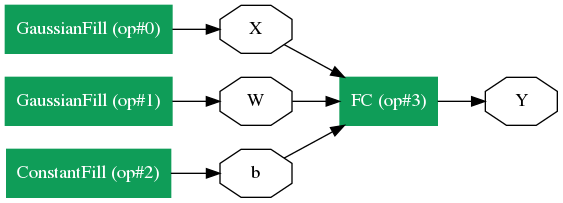

In [8]:
from caffe2.python import net_drawer
from IPython import display
graph = net_drawer.GetPydotGraph(net, rankdir="LR")
display.Image(graph.create_png(), width=800)

我们已经定义了一个网络，但是没有执行任何内容。请记住，网络的本质上是一个保存网络定义的`protobuf`。当我们真正运行网络时，接下来会发生的事情：

1. 从这个protobuf实例化C++网络对象。
2. 调用实例化的net的Run()函数

在我们使用之前，我们应该使用`ResetWrokspace()`清楚早期的工作空间的变量。

有两种方式从Python运行一个网络。
1. 使用workspace.RunNetOnce()实例化，运行并且释放这个网络。
2. 稍微有一点复杂，涉及两部操作：(a) 调用workspace.CreateNet()来创建空工作空间所拥有的C++网络对象，(b) 通过网络名称传递给它来使用workspace.RunNet()。

In [9]:
workspace.ResetWorkspace()
print("Current blobs in the workspace: {}".format(workspace.Blobs()))
workspace.RunNetOnce(net)
print("Blobs in the workspace after execution: {}".format(workspace.Blobs()))
# Let's dump the contents of the blobs
for name in workspace.Blobs():
    print("{}:\n{}".format(name, workspace.FetchBlob(name)))

Current blobs in the workspace: []
Blobs in the workspace after execution: [u'W', u'X', u'Y', u'b']
W:
[[-1.8771137   0.92778355 -0.08161756]
 [-0.12097193 -2.1138864   1.2284073 ]
 [-0.60585827 -0.2562339   0.4624799 ]
 [-0.19854297  2.1087546  -0.6328412 ]
 [-0.6575426   0.6579211  -0.1453419 ]]
X:
[[-0.6132486  -2.3268244   0.21757394]
 [ 0.5726079  -0.61902726 -0.01467536]]
Y:
[[-0.02540994  6.260098    2.0683765  -3.922635   -0.1592524 ]
 [-0.64797556  2.2212565   0.80490947 -0.4097768   0.21834779]]
b:
[1. 1. 1. 1. 1.]


现在让我们尝试第二种方法来创建网络并运行它。 

1. 首先，使用`ResetWorkspace()`清除变量。 

2. 然后使用`CreateNet(net_object)`创建我们之前创建的工作空间的net对象。 

3. 最后，使用`RunNet(net_name)`运行网络。

In [10]:
workspace.ResetWorkspace()
print("Current blobs in the workspace: {}".format(workspace.Blobs()))
workspace.CreateNet(net)
workspace.RunNet(net.Proto().name)
print("Blobs in the workspace after execution: {}".format(workspace.Blobs()))
for name in workspace.Blobs():
    print("{}:\n{}".format(name, workspace.FetchBlob(name)))

Current blobs in the workspace: []
Blobs in the workspace after execution: [u'W', u'X', u'Y', u'b']
W:
[[-0.72495663  0.3761383  -0.66840994]
 [ 0.04286987  1.9306209  -0.52174044]
 [ 0.24631721  0.50984025  1.4499642 ]
 [ 2.0171852   0.31425178 -0.6691781 ]
 [-0.2863933  -0.40237466 -0.34997916]]
X:
[[-0.7392328   0.29804215  0.7010549 ]
 [ 0.97545576  0.19705464 -2.5136533 ]]
Y:
[[ 1.1794248   1.1779469   1.9863725  -0.86663985  0.84643215]
 [ 2.0471077   2.73373    -2.3039694   4.7116814   1.5210725 ]]
b:
[1. 1. 1. 1. 1.]


RunNetOnce和RunNet之间有一些区别，但可能主要的区别是计算时间开销。 

由于RunNetOnce涉及序列化在Python和C之间传递的protobuf并实例化网络，因此运行可能需要更长的时间。 

让我们来看看这种情况下的开销是多少。

In [11]:
# It seems that %timeit magic does not work well with
# C++ extensions so we'll basically do for loops
start = time.time()
for i in range(1000):
    workspace.RunNetOnce(net)
end = time.time()
print('Run time per RunNetOnce: {}'.format((end - start) / 1000))

start = time.time()
for i in range(1000):
    workspace.RunNet(net.Proto().name)
end = time.time()
print('Run time per RunNet: {}'.format((end - start) / 1000))

Run time per RunNetOnce: 5.71908950806e-05
Run time per RunNet: 4.70399856567e-06
